# Outline
- [Part 1: Data preparation](#1)
    - [1.1  Data cleaning](#1.1)
    - [1.2  Train test split](#1.2)
- [Part 2:  Model build](#2)
    - [2.0  Logistic model pipeline](#2.0)
    - [2.1  Logistic model](#2.1)
    - [2.2  Logistic grid search](#2.2)
    - [2.3  GBT](#2.3)
- [Part 3:  Evaluation and calibration curve](#3)
    - [3.1  Performance](#3.1)
    - [3.2  Calibration](#3.2)

<a name="1"></a>
# Part 1:  Data preparation

<a name="1.1"></a>
## 1.1 Data cleaning

In [1]:
# packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore') 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve, log_loss

In [2]:
# import data
df = pd.read_csv('case_data.csv', sep = ';')
df.head()

,ApplicationDate,requested_amount,has_co_adress,CivilStatus,NrOfChildren,age,Has_Co_Appl_Flag,UC_Req_L3M,UC_Req_L6M,UC_Req_L12M,...,Has_Mortgage,default_flag,income_year1,income_year2,refinance_flag,has_repayment_loan,has_creditcard_loan,gender,broker_id,NrOfCars
0,52019,30000,0,Married,1,33,0,7,16,19,...,1,0,"$274,100.00","$142,300.00",0,1,1,M,10,4
1,52019,50000,0,Single,0,29,0,6,8,12,...,0,0,"$231,600.00","$82,100.00",0,1,1,M,14,4
2,52019,100000,0,Cohabiting,1,40,0,2,3,5,...,0,0,"$248,900.00","$255,800.00",1,1,1,F,14,5
3,52019,150000,1,Cohabiting,1,37,0,8,12,22,...,0,0,"$278,000.00","$34,400.00",1,0,1,F,14,1
4,52019,70000,0,Single,0,61,0,1,2,3,...,0,0,"$283,000.00","$264,800.00",1,0,1,M,10,3


In [3]:
# keep refinance loan only, volume is good
df = df[df.refinance_flag == 1]
pd.crosstab(index = df.default_flag, columns = "count")

col_0,count
default_flag,
0,15883
1,1286


In [4]:
# check variables
# bureau score 1-100 scale pd?
# rule cap applicantage at 70?
# income_year1 has missing
print(f'shape: {df.shape}')
df.info()

shape: (17169, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17169 entries, 2 to 24998
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ApplicationDate      17169 non-null  int64  
 1   requested_amount     17169 non-null  int64  
 2   has_co_adress        17169 non-null  int64  
 3   CivilStatus          17169 non-null  object 
 4   NrOfChildren         17169 non-null  int64  
 5   age                  17169 non-null  int64  
 6   Has_Co_Appl_Flag     17169 non-null  int64  
 7   UC_Req_L3M           17169 non-null  int64  
 8   UC_Req_L6M           17169 non-null  int64  
 9   UC_Req_L12M          17169 non-null  int64  
 10  Bureau_Score         17169 non-null  float64
 11  Blanco_loan_debt     17169 non-null  int64  
 12  NumberOfLoans        17169 non-null  int64  
 13  Has_Mortgage         17169 non-null  int64  
 14  default_flag         17169 non-null  int64  
 15  income_year1     

In [5]:
# numerical 
df.describe()

,ApplicationDate,requested_amount,has_co_adress,NrOfChildren,age,Has_Co_Appl_Flag,UC_Req_L3M,UC_Req_L6M,UC_Req_L12M,Bureau_Score,Blanco_loan_debt,NumberOfLoans,Has_Mortgage,default_flag,refinance_flag,has_repayment_loan,has_creditcard_loan,broker_id,NrOfCars
count,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.000000,17169.0,17169.000000,17169.000000,17169.000000,17169.000000
mean,72653.962083,212898.829285,0.023589,0.575514,42.398101,0.008911,4.894985,8.061157,13.584484,8.090524,278802.270720,7.090046,0.279108,0.074902,1.0,0.359077,0.829344,9.537655,3.003961
std,34300.765629,139805.280241,0.151769,0.906586,13.025747,0.093981,5.139059,9.890081,14.918265,6.326479,193766.091164,4.155294,0.448574,0.263242,0.0,0.479744,0.376219,4.132714,2.124637
min,12020.000000,10000.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,1.000000,0.000000
25%,52019.000000,100000.000000,0.000000,0.000000,31.000000,0.000000,2.000000,3.000000,6.000000,2.800000,112234.000000,4.000000,0.000000,0.000000,1.0,0.000000,1.000000,8.000000,1.000000
50%,82019.000000,200000.000000,0.000000,0.000000,41.000000,0.000000,3.000000,6.000000,10.000000,6.400000,262144.000000,6.000000,0.000000,0.000000,1.0,0.000000,1.000000,10.000000,3.000000
75%,102019.000000,310000.000000,0.000000,1.000000,53.000000,0.000000,6.000000,10.000000,17.000000,12.400000,422548.000000,9.000000,1.000000,0.000000,1.0,1.000000,1.000000,13.000000,4.000000
max,122020.000000,500000.000000,1.000000,7.000000,70.000000,1.000000,228.000000,798.000000,1026.000000,73.300000,799241.000000,42.000000,1.000000,1.000000,1.0,1.000000,1.000000,16.000000,10.000000


In [6]:
# categorical
display(df.describe(include=['O']))
df.CivilStatus.unique()

,CivilStatus,income_year1,income_year2,gender
count,17169,16310,17169,17169
unique,3,3960,4670,2
top,Single,"$255,800.00",$0.00,M
freq,6010,16,41,10023


array(['Cohabiting', 'Single', 'Married'], dtype=object)

In [7]:
# dtype clean up
# convert to numeric var
df['income_year1'] = df['income_year1'].str.replace('$','').str.replace(',', '').astype(float)
df['income_year2'] = df['income_year2'].str.replace('$','').str.replace(',', '').astype(float)

# convert to str var
df['broker_id'] = df['broker_id'].astype(str)

# date to MMYYY
df['ApplicationYear_str'] = df.ApplicationDate.astype(str).str[-4:]
df['ApplicationMonth_str'] = "0" + df.ApplicationDate.astype(str).str[0:-4]
df['ApplicationMonth_str'] = df['ApplicationMonth_str'].str[-2:]
df['ApplicationDate'] = df.ApplicationYear_str + df.ApplicationMonth_str

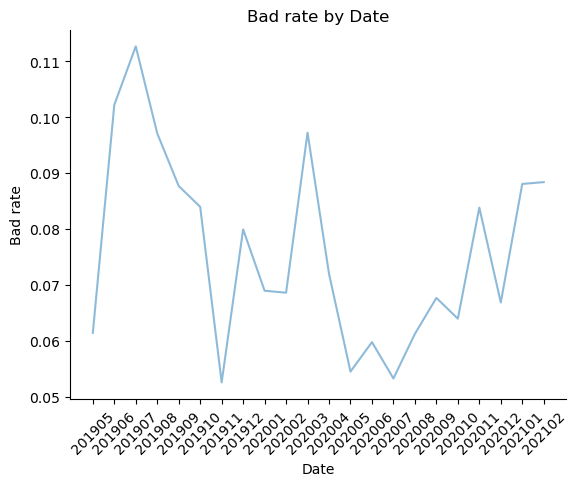

In [8]:
# check vintages
bad_rate = pd.crosstab(df.ApplicationDate, df.default_flag,normalize='index')
# display(bad_rate)

# Plotting the time series of bad rate
# looks ok
plt.plot(bad_rate.index, bad_rate.iloc[:,1], alpha = 0.5)

plt.title('Bad rate by Date')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Bad rate')
plt.gca().spines[['right','top']].set_visible(False)

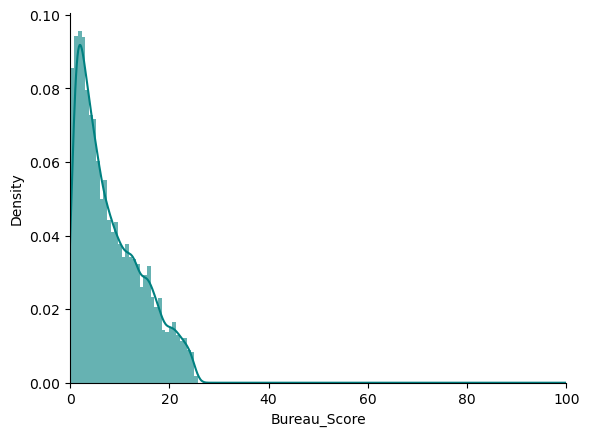

Bureau score has auc: 


0.5087190849024393

In [9]:
# have a look at bureau score
ax = df["Bureau_Score"].hist(bins=100, density=True, stacked=True, color='teal', alpha=0.6)
df["Bureau_Score"].plot(kind='density', color='teal')
ax.set(xlabel='Bureau_Score')
plt.gca().spines[['right','top']].set_visible(False)
plt.xlim(0,100)
plt.show()

print(f'Bureau score has auc: ')
roc_auc_score(df['default_flag'], df['Bureau_Score'])

In [10]:
# drop unwanted variables 
drop_lst = ['broker_id','ApplicationDate','Bureau_Score','refinance_flag','gender', 'ApplicationMonth_str', 'ApplicationYear_str']
df_clean = df.drop(drop_lst, axis=1)

<a name="1.1"></a>
## 1.1 Train test split

In [11]:
# train test split
bad_def = 'default_flag'
features = df_clean.columns.drop(bad_def)

X_train, X_test, y_train, y_test = train_test_split(df_clean[features], df_clean[bad_def], test_size = 0.3, random_state = 1, stratify = df_clean[bad_def])

In [12]:
# group features
str_lst = [] 
num_lst = []

num_lst = X_train[features].select_dtypes('number').columns
print(f"Numerical features: \n{', '.join(num_lst)}")

str_lst = pd.Index(np.setdiff1d(features, num_lst))
print(f"\nCategorical features: \n{', '.join(str_lst)}")

Numerical features: 
requested_amount, has_co_adress, NrOfChildren, age, Has_Co_Appl_Flag, UC_Req_L3M, UC_Req_L6M, UC_Req_L12M, Blanco_loan_debt, NumberOfLoans, Has_Mortgage, income_year1, income_year2, has_repayment_loan, has_creditcard_loan, NrOfCars

Categorical features: 
CivilStatus


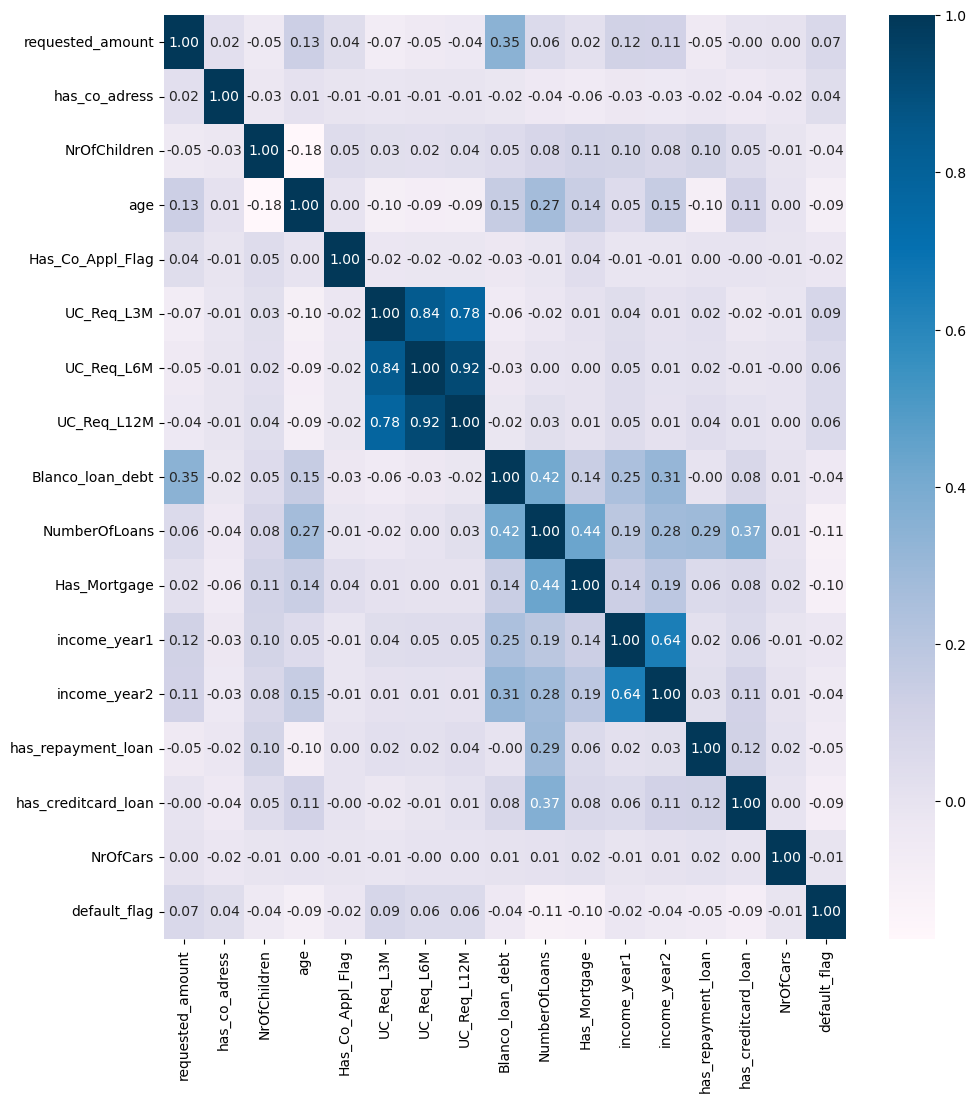

Strong numerical features: 
NumberOfLoans          0.113929
Has_Mortgage           0.104850
age                    0.091525
UC_Req_L3M             0.089519
has_creditcard_loan    0.086246
requested_amount       0.074346
UC_Req_L12M            0.062054
UC_Req_L6M             0.060959
has_repayment_loan     0.053424
Name: default_flag, dtype: float64


In [13]:
# correlation matrix
df_train_num = pd.concat([X_train[num_lst],y_train], axis=1)
cor = df_train_num.corr()

plt.subplots(figsize=(11, 12))
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu, fmt='.2f')
plt.show()

# Get the absolute value of the correlation
cor_target = abs(cor[bad_def])

# strong numerical candidates 
threshold = 0.05
strong_features = cor_target[cor_target > threshold].sort_values(ascending=False)[1:]
print(f'Strong numerical features: \n{strong_features}')

In [14]:
# check data
# printing inf and nan column name
print("printing column name that has inf")
print(df_train_num.columns.to_series()[np.isinf(df_train_num).any()])

print("\nprinting column name that has nan")
print(df_train_num.columns.to_series()[np.isnan(df_train_num).any()])

printing column name that has inf
Series([], dtype: object)

printing column name that has nan
income_year1    income_year1
dtype: object


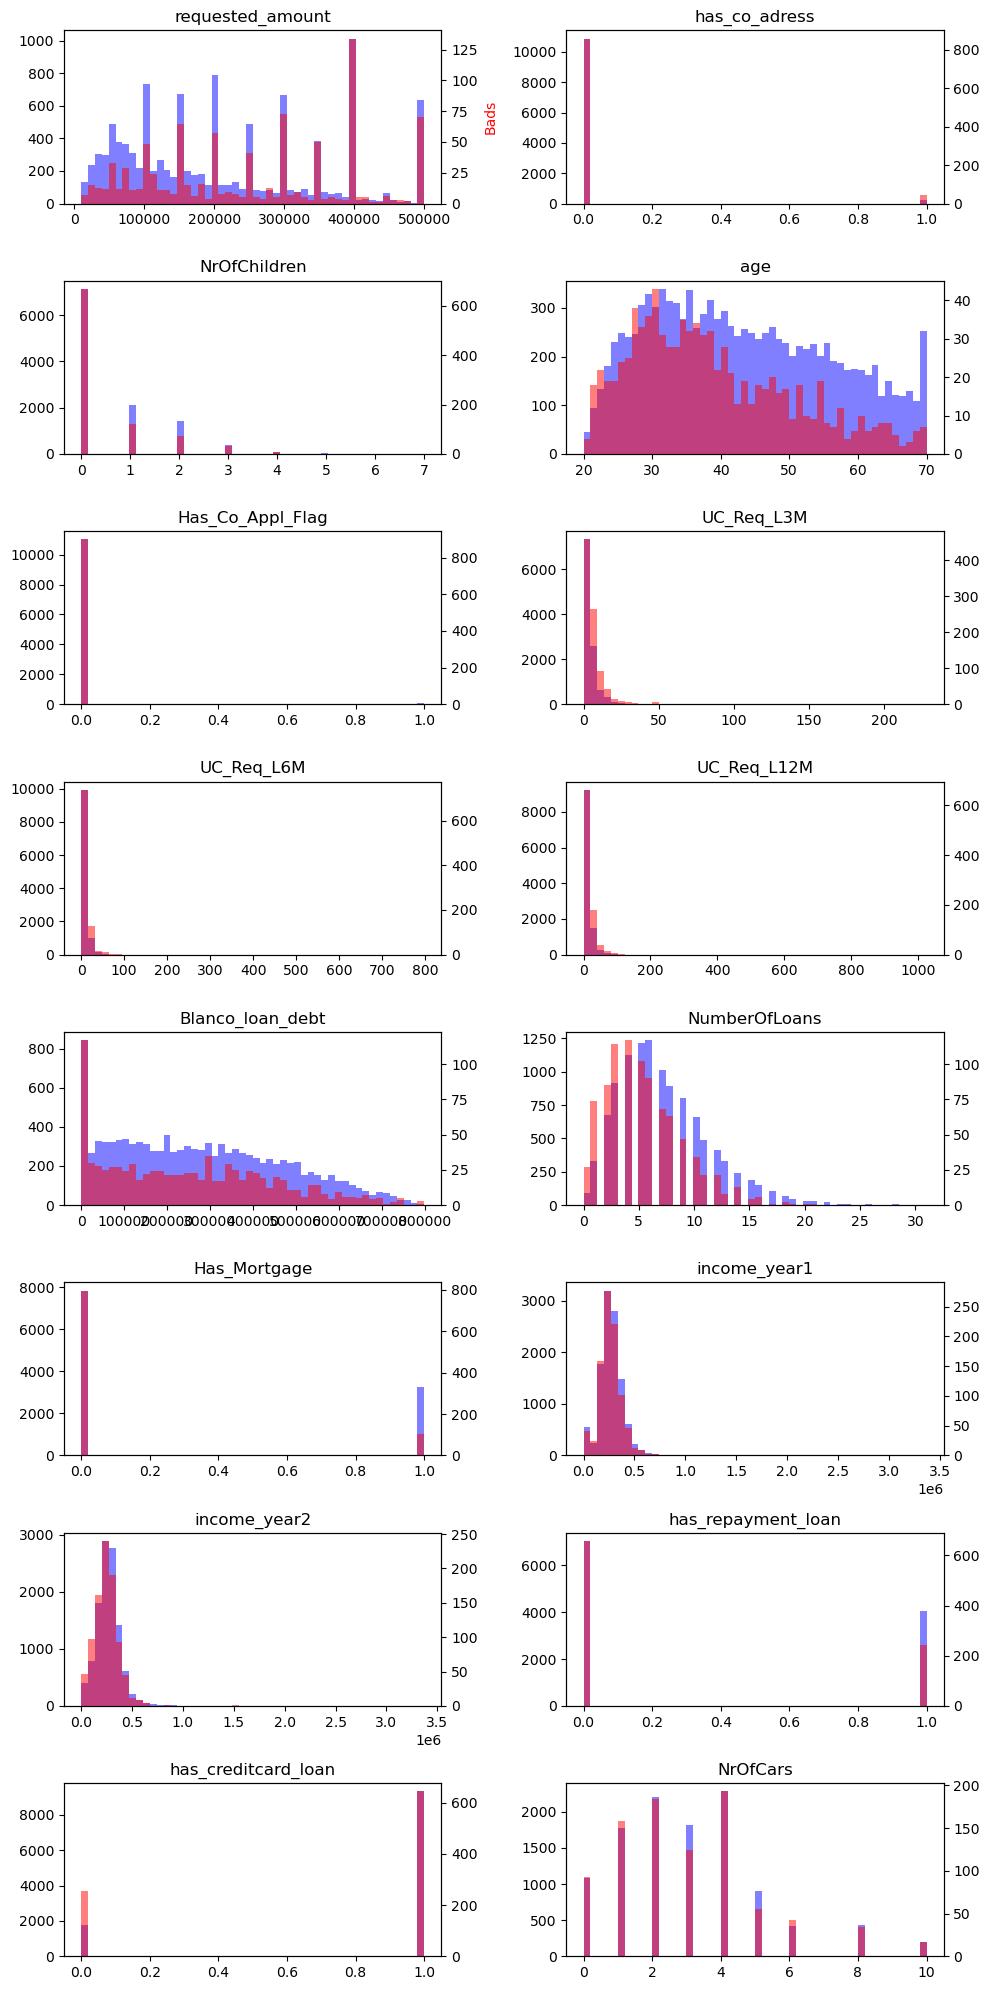

In [15]:
# Plot features correlation with target variable desc
# replace nan with 0 for now on
df_plot = df_train_num.replace(np.nan, 0)

good = df_plot[df_plot[bad_def] == 0]
bad =  df_plot[df_plot[bad_def] == 1]

fig, axes = plt.subplots(int(np.ceil((df_train_num.shape[1] - 1)/2)), 2, figsize=(10, 20))
ax = axes.ravel()
ax2 = ax
for i in range(df_train_num.shape[1] - 1):
    _, bins = np.histogram(df_plot.iloc[:, i], bins=50)
    ax[i].hist(good.iloc[:, i], bins=bins, color='b', alpha=.5)
    ax2[i] = ax[i].twinx()
    ax2[i].hist(bad.iloc[:, i], bins=bins, color='r', alpha=.5)
    ax[i].set_title(df_plot.columns[i])
    ax2[0].set_ylabel("Bads", color='r')

    fig.tight_layout()

<a name="2"></a>
# Part 2: Model build

<a name="2.0"></a>
## 2.0 Logistic model pipeline

In [16]:
# build model
numerical_pipe = Pipeline([
('imputer', SimpleImputer(strategy='constant', fill_value= 0)),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_lst),
    ('cat', categorical_pipe, str_lst)
])

pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression(random_state = 1))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['requested_amount', 'has_co_adress', 'NrOfChildren', 'age',
       'Has_Co_Appl_Flag', 'UC_Req_L3M', 'UC_Req_L6M', 'UC_Req_L12M',
       'Blanco_loan_debt', 'NumberOfLoans', 'Has_Mortgage',...ar1',
       'income_year2', 'has_repayment_loan', 'has_creditcard_loan',
       'NrOfCars'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['CivilStatus'], dtype='object'))])),
                ('model', LogisticRegression(random_state=1))])

<a name="2.1"></a>
## 2.1 Logistic model

In [17]:
# performance metric
def get_perf(model_data, X_input, y_act, index_name):
    """
    calculate performance
    
    parameters:
    model_data: pipeline
    X_input: features
    y_act: target
    index_name: e.g. train, test, oot  

    """

    y_pred = model_data.predict(X_input)
    y_pred_prob = model_data.predict_proba(X_input)[:, 1]

    from sklearn.metrics import accuracy_score, roc_auc_score
    from scipy.stats import ks_2samp

    # KS calculation steps
    df_t = pd.DataFrame()
    df_t['true'] = y_act
    df_t['proba'] = y_pred_prob
    
    # Recover each class
    class0 = df_t[df_t['true'] == 0]
    class1 = df_t[df_t['true'] == 1]
    
    results = {
        'ROC_AUC': [roc_auc_score(y_act, y_pred_prob)],
        'Gini': [2*roc_auc_score(y_act, y_pred_prob)-1],
        'KS':[ks_2samp(class0['proba'], class1['proba']).statistic],
        'Log loss':[log_loss(y_act, y_pred_prob)],
        'Accuracy':[accuracy_score(y_act, y_pred)],
        'Actual bad rate':[y_act.mean()],
        'Expected bad rate':[y_pred_prob.mean()]
    }   
    df_results = pd.DataFrame(results, index = [index_name])
    return df_results

res = get_perf(pipe,X_train, y_train, 'Train')
res = res.append(get_perf(pipe,X_test, y_test, 'Test'))
res

,ROC_AUC,Gini,KS,Log loss,Accuracy,Actual bad rate,Expected bad rate
Train,0.724382,0.448764,0.346968,0.242559,0.924613,0.074888,0.074888
Test,0.711127,0.422254,0.310220,0.245985,0.924287,0.074937,0.074905


<a name="2.2"></a>
## 2.2 Logistic grid search

In [18]:
# if time allows, run grid search
# pipe.get_params()

# grid search
grid_params = {
    'model__C': np.logspace(-4, 4, 100),
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs','liblinear','saga','newton-cg']
}

# use multiple scorers
scoring = {'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

# set timer
start_time = time.time()

# create gridsearchCV object
gs = GridSearchCV(pipe, grid_params, scoring=scoring, n_jobs=-1, refit='AUC')
gs.fit(X_train, y_train)

print(f'best parameters L2: \n{gs.best_params_}')
print('this takes %s sec' % (time.time() - start_time))

best parameters L2: 
{'model__C': 0.20565123083486536, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
this takes 66.34953165054321 sec


In [19]:
# grid search L1 for fewer features
grid_params = {
    'model__C': np.logspace(-4, 4, 100),
    'model__penalty': ['l1'],
    'model__solver': ['saga']
}

# use multiple scorers
scoring = {'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

# set timer
start_time = time.time()

# create gridsearchCV object
gs_l1 = GridSearchCV(pipe, grid_params, scoring=scoring, n_jobs=-1, refit='AUC')
gs_l1.fit(X_train, y_train)

print(f'best parameters L1: \n{gs_l1.best_params_}')
print('this takes %s sec' % (time.time() - start_time))

best parameters L1: 
{'model__C': 0.04641588833612782, 'model__penalty': 'l1', 'model__solver': 'saga'}
this takes 33.841835021972656 sec


In [20]:
# save best estimators and print result
best_est = gs.best_estimator_
best_est_l1 = gs_l1.best_estimator_

res = res.append(get_perf(best_est,X_train, y_train, 'Train_gs'))
res = res.append(get_perf(best_est,X_test, y_test, 'Test_gs'))
res = res.append(get_perf(best_est_l1,X_train, y_train, 'Train_gs_l1'))
res = res.append(get_perf(best_est_l1,X_test, y_test, 'Test_gs_l1'))
res

,ROC_AUC,Gini,KS,Log loss,Accuracy,Actual bad rate,Expected bad rate
Train,0.724382,0.448764,0.346968,0.242559,0.924613,0.074888,0.074888
Test,0.711127,0.422254,0.310220,0.245985,0.924287,0.074937,0.074905
Train_gs,0.724333,0.448667,0.345455,0.242565,0.924613,0.074888,0.074887
Test_gs,0.711204,0.422408,0.305393,0.245937,0.924287,0.074937,0.074893
Train_gs_l1,0.719910,0.439820,0.325956,0.244101,0.925112,0.074888,0.075345
Test_gs_l1,0.713105,0.426211,0.328676,0.245894,0.925063,0.074937,0.075377


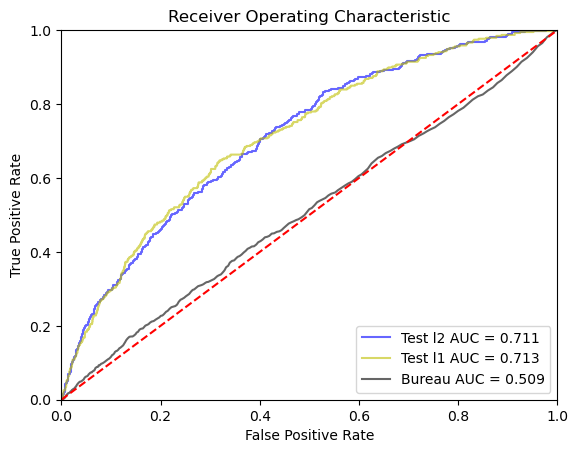

In [21]:
# ROC plots
# calculate the fpr and tpr 
pred_test = pipe.predict_proba(X_test)[:,1]
pred_test_gs = best_est.predict_proba(X_test)[:,1]
pred_test_gs_l1 = best_est_l1.predict_proba(X_test)[:,1]

fpr0, tpr0, _ = roc_curve(df[bad_def], df['Bureau_Score'])
fpr1, tpr1, _ = roc_curve(y_test, pred_test)
fpr2, tpr2, _ = roc_curve(y_test, pred_test_gs)
fpr3, tpr3, _ = roc_curve(y_test, pred_test_gs_l1)

roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.title('Receiver Operating Characteristic')
# plt.plot(fpr1, tpr1, 'g', label = 'Test AUC = %0.3f' % roc_auc1, alpha = 0.6)
plt.plot(fpr2, tpr2, 'b', label = 'Test l2 AUC = %0.3f' % roc_auc2, alpha = 0.6)
plt.plot(fpr3, tpr3, 'y', label = 'Test l1 AUC = %0.3f' % roc_auc3, alpha = 0.6)
plt.plot(fpr0, tpr0, 'black', label = 'Bureau AUC = %0.3f' % roc_auc0, alpha = 0.6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
# get all features
features = list(best_est_l1.named_steps['preprocessors']\
                  .named_transformers_['num']\
                  .get_feature_names_out())\
                 + list(best_est_l1.named_steps['preprocessors']\
                  .named_transformers_['cat']\
                  .get_feature_names_out())\
                + ['intercept']

# get all coeffcients 
all_coef = best_est['model'].coef_.flatten().tolist() + best_est['model'].intercept_.tolist()
all_coef2 = best_est_l1['model'].coef_.flatten().tolist() + best_est_l1['model'].intercept_.tolist()

# initialize data of lists.
data = {'Model': all_coef,
        'Model_l1': all_coef2}

coeff = pd.DataFrame(data, index=features)
coeff

,Model,Model_l1
requested_amount,0.409160,0.361162
has_co_adress,0.093955,0.079573
NrOfChildren,-0.126499,-0.109850
age,-0.330268,-0.281055
Has_Co_Appl_Flag,-0.188627,-0.090915
UC_Req_L3M,0.376693,0.239246
UC_Req_L6M,-0.313919,-0.004340
UC_Req_L12M,0.165994,0.000000
Blanco_loan_debt,-0.098666,-0.071477
NumberOfLoans,-0.137034,-0.159866


<a name="2.3"></a>
## 2.3 GBT

In [440]:
# if time allows, run gbt
############ GBT #####################

In [24]:
# GBT data prep
# transfer to numbered categorical features for later calibration 
from sklearn.preprocessing import OrdinalEncoder
ordinal_enc = OrdinalEncoder()
temp = np.array(X_train['CivilStatus']).reshape((len(X_train['CivilStatus']), 1))
temp_test = np.array(X_test['CivilStatus']).reshape((len(X_test['CivilStatus']), 1))

ordinal_enc.fit(temp)

X_train['CivilStatus'] = ordinal_enc.transform(temp).astype(str)
X_test['CivilStatus'] = ordinal_enc.transform(temp_test).astype(str)

# replace missing
X_train['income_year1'] = X_train['income_year1'].replace(np.nan, 0)
X_test['income_year1'] = X_test['income_year1'].replace(np.nan, 0)

#create pool object
from catboost import Pool, CatBoostClassifier
def pool_data(X,y):
    cat_pool = Pool(
    data = X, 
    label = y, 
    cat_features = np.where(X.dtypes != float)[0]
    )
    return cat_pool

pool_train = pool_data(X_train, y_train)
pool_test = pool_data(X_test, y_test)

In [25]:
# GBT no iteration version for quick result
iter = 500
alpha = 0.015
dep = 4
L2 = 100
stop = 10

model_final = CatBoostClassifier(
    iterations = iter,
    learning_rate= alpha,
    # custom_loss=['AUC', 'Accuracy','Precision', 'Recall'],
    max_depth = dep,
    l2_leaf_reg = L2,
    early_stopping_rounds = stop
)

model_final.fit(X_train, y_train, 
        cat_features=np.where(X_train.dtypes != float)[0], 
        eval_set=(X_test, y_test), 
        verbose=False
)

new_line = '\n'
print('Model is fitted: {}'.format(model_final.is_fitted()))
print('Model params:\n{}'.format(model_final.get_params()))

gbt_res = get_perf(model_final, X_train, y_train, 'Train_gbt')
gbt_res = gbt_res.append(get_perf(model_final, X_test, y_test, 'Test_bgt'))
display(gbt_res)

Model is fitted: True
Model params:
{'iterations': 500, 'learning_rate': 0.015, 'l2_leaf_reg': 100, 'max_depth': 4, 'early_stopping_rounds': 10}


,ROC_AUC,Gini,KS,Log loss,Accuracy,Actual bad rate,Expected bad rate
Train_gbt,0.769071,0.538141,0.408823,0.235808,0.925112,0.074888,0.074051
Test_bgt,0.722367,0.444735,0.346664,0.244835,0.925063,0.074937,0.073611


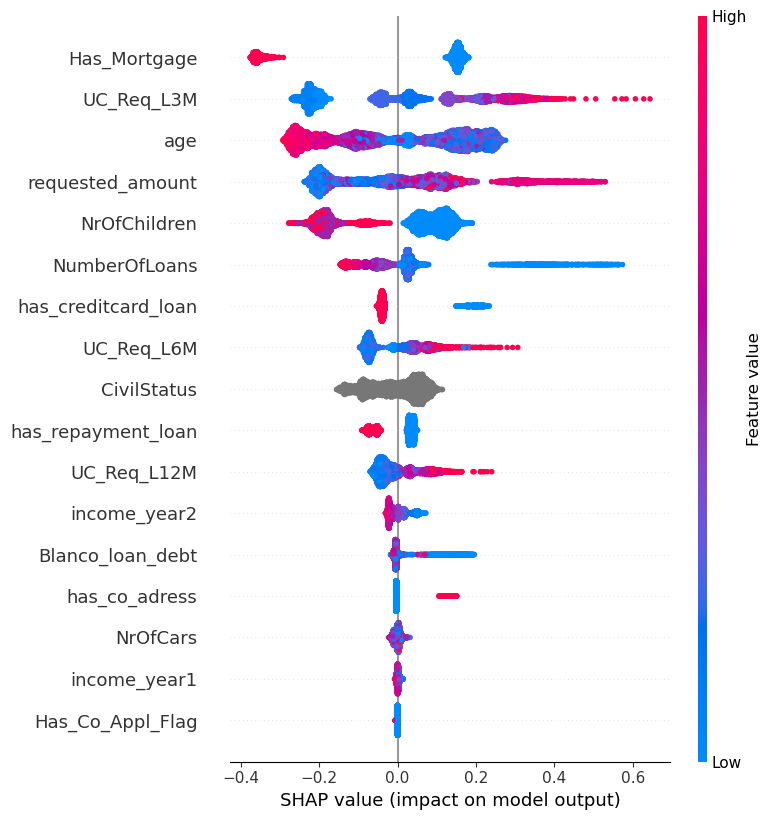

In [26]:
# SHAP explainer
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_train) 

shap.summary_plot(shap_values, X_train)

<a name="3"></a>
# Part 3: Evaluation

<a name="3.1"></a>
## 3.1 Performance

In [27]:
############ All together #####################
# stack all the results
res = res.append(gbt_res)
res

,ROC_AUC,Gini,KS,Log loss,Accuracy,Actual bad rate,Expected bad rate
Train,0.724382,0.448764,0.346968,0.242559,0.924613,0.074888,0.074888
Test,0.711127,0.422254,0.310220,0.245985,0.924287,0.074937,0.074905
Train_gs,0.724333,0.448667,0.345455,0.242565,0.924613,0.074888,0.074887
Test_gs,0.711204,0.422408,0.305393,0.245937,0.924287,0.074937,0.074893
Train_gs_l1,0.719910,0.439820,0.325956,0.244101,0.925112,0.074888,0.075345
Test_gs_l1,0.713105,0.426211,0.328676,0.245894,0.925063,0.074937,0.075377
Train_gbt,0.769071,0.538141,0.408823,0.235808,0.925112,0.074888,0.074051
Test_bgt,0.722367,0.444735,0.346664,0.244835,0.925063,0.074937,0.073611


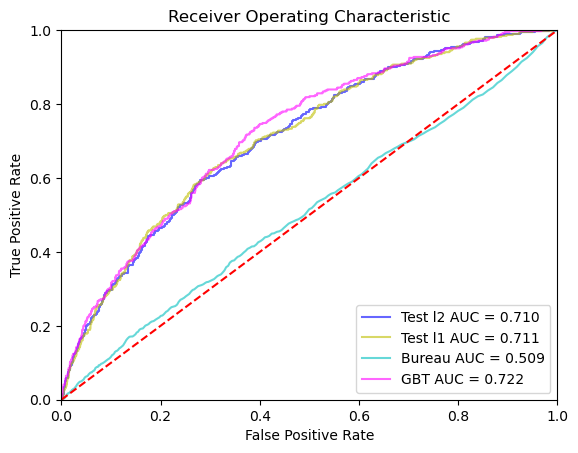

In [28]:
# ROC plots
# calculate the fpr and tpr 
pred_test = pipe.predict_proba(X_test)[:,1]
pred_test_gs = best_est.predict_proba(X_test)[:,1]
pred_test_gs_l1 = best_est_l1.predict_proba(X_test)[:,1]

fpr0, tpr0, _ = roc_curve(df[bad_def], df['Bureau_Score'])
fpr1, tpr1, _ = roc_curve(y_test, pred_test)
fpr2, tpr2, _ = roc_curve(y_test, pred_test_gs)
fpr3, tpr3, _ = roc_curve(y_test, pred_test_gs_l1)

roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

#gbt
from catboost.utils import get_roc_curve

curve = get_roc_curve(model_final, pool_test)
(fpr, tpr, thresholds) = curve
roc_auc = roc_auc_score(y_test, model_final.predict_proba(X_test)[:, 1])

plt.title('Receiver Operating Characteristic')
# plt.plot(fpr1, tpr1, 'g', label = 'Test AUC = %0.3f' % roc_auc1, alpha = 0.6)
plt.plot(fpr2, tpr2, 'b', label = 'Test l2 AUC = %0.3f' % roc_auc2, alpha = 0.6)
plt.plot(fpr3, tpr3, 'y', label = 'Test l1 AUC = %0.3f' % roc_auc3, alpha = 0.6)
plt.plot(fpr0, tpr0, 'c', label = 'Bureau AUC = %0.3f' % roc_auc0, alpha = 0.6)
plt.plot(fpr, tpr, 'magenta', label = 'GBT AUC = %0.3f' % roc_auc, alpha = 0.6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a name="3.2"></a>
## 3.2 Calibration

In [29]:
# calibrate gbt
from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model_final, method='sigmoid', cv=5).fit(X_train, y_train)

# predict probabilities
pred_test_cal_gbt = calibrated.predict_proba(X_test)[:, 1]

0:	learn: 0.6771084	total: 3.72ms	remaining: 1.86s
1:	learn: 0.6616020	total: 6.73ms	remaining: 1.68s
2:	learn: 0.6466506	total: 9.58ms	remaining: 1.59s
3:	learn: 0.6324815	total: 12.3ms	remaining: 1.52s
4:	learn: 0.6184097	total: 14.7ms	remaining: 1.46s
5:	learn: 0.6052666	total: 17.1ms	remaining: 1.41s
6:	learn: 0.5922360	total: 19.4ms	remaining: 1.37s
7:	learn: 0.5796718	total: 21.9ms	remaining: 1.34s
8:	learn: 0.5675601	total: 25ms	remaining: 1.36s
9:	learn: 0.5559622	total: 27.9ms	remaining: 1.37s
10:	learn: 0.5449527	total: 30.9ms	remaining: 1.37s
11:	learn: 0.5344361	total: 34ms	remaining: 1.38s
12:	learn: 0.5239588	total: 37ms	remaining: 1.39s
13:	learn: 0.5143016	total: 40.1ms	remaining: 1.39s
14:	learn: 0.5051560	total: 43.1ms	remaining: 1.39s
15:	learn: 0.4961959	total: 46.2ms	remaining: 1.4s
16:	learn: 0.4876366	total: 49.2ms	remaining: 1.4s
17:	learn: 0.4788803	total: 52.2ms	remaining: 1.4s
18:	learn: 0.4707572	total: 55.3ms	remaining: 1.4s
19:	learn: 0.4630558	total: 58.6

189:	learn: 0.2444950	total: 611ms	remaining: 997ms
190:	learn: 0.2443775	total: 614ms	remaining: 994ms
191:	learn: 0.2442951	total: 618ms	remaining: 991ms
192:	learn: 0.2442064	total: 621ms	remaining: 987ms
193:	learn: 0.2441120	total: 624ms	remaining: 984ms
194:	learn: 0.2440210	total: 627ms	remaining: 981ms
195:	learn: 0.2438877	total: 631ms	remaining: 978ms
196:	learn: 0.2437891	total: 634ms	remaining: 975ms
197:	learn: 0.2436739	total: 637ms	remaining: 971ms
198:	learn: 0.2435958	total: 640ms	remaining: 968ms
199:	learn: 0.2435210	total: 643ms	remaining: 965ms
200:	learn: 0.2434146	total: 647ms	remaining: 962ms
201:	learn: 0.2433103	total: 650ms	remaining: 959ms
202:	learn: 0.2432165	total: 653ms	remaining: 956ms
203:	learn: 0.2431284	total: 657ms	remaining: 953ms
204:	learn: 0.2430563	total: 660ms	remaining: 950ms
205:	learn: 0.2429487	total: 663ms	remaining: 946ms
206:	learn: 0.2428722	total: 666ms	remaining: 943ms
207:	learn: 0.2428057	total: 670ms	remaining: 940ms
208:	learn: 

373:	learn: 0.2366295	total: 1.21s	remaining: 407ms
374:	learn: 0.2366080	total: 1.21s	remaining: 404ms
375:	learn: 0.2365996	total: 1.21s	remaining: 400ms
376:	learn: 0.2365962	total: 1.22s	remaining: 397ms
377:	learn: 0.2365931	total: 1.22s	remaining: 394ms
378:	learn: 0.2365789	total: 1.22s	remaining: 391ms
379:	learn: 0.2365546	total: 1.23s	remaining: 388ms
380:	learn: 0.2365427	total: 1.23s	remaining: 384ms
381:	learn: 0.2365161	total: 1.23s	remaining: 381ms
382:	learn: 0.2365016	total: 1.24s	remaining: 378ms
383:	learn: 0.2364731	total: 1.24s	remaining: 375ms
384:	learn: 0.2364682	total: 1.24s	remaining: 371ms
385:	learn: 0.2364301	total: 1.25s	remaining: 368ms
386:	learn: 0.2364171	total: 1.25s	remaining: 365ms
387:	learn: 0.2364059	total: 1.25s	remaining: 362ms
388:	learn: 0.2363608	total: 1.26s	remaining: 359ms
389:	learn: 0.2363326	total: 1.26s	remaining: 355ms
390:	learn: 0.2363257	total: 1.26s	remaining: 352ms
391:	learn: 0.2363154	total: 1.26s	remaining: 349ms
392:	learn: 

92:	learn: 0.2681929	total: 334ms	remaining: 1.46s
93:	learn: 0.2676066	total: 337ms	remaining: 1.46s
94:	learn: 0.2669856	total: 340ms	remaining: 1.45s
95:	learn: 0.2664115	total: 344ms	remaining: 1.45s
96:	learn: 0.2657988	total: 347ms	remaining: 1.44s
97:	learn: 0.2651228	total: 350ms	remaining: 1.44s
98:	learn: 0.2645370	total: 353ms	remaining: 1.43s
99:	learn: 0.2639034	total: 357ms	remaining: 1.43s
100:	learn: 0.2633906	total: 360ms	remaining: 1.42s
101:	learn: 0.2628342	total: 363ms	remaining: 1.42s
102:	learn: 0.2624112	total: 366ms	remaining: 1.41s
103:	learn: 0.2618964	total: 369ms	remaining: 1.4s
104:	learn: 0.2615251	total: 372ms	remaining: 1.4s
105:	learn: 0.2611129	total: 375ms	remaining: 1.39s
106:	learn: 0.2606253	total: 378ms	remaining: 1.39s
107:	learn: 0.2601374	total: 381ms	remaining: 1.38s
108:	learn: 0.2597683	total: 384ms	remaining: 1.38s
109:	learn: 0.2593757	total: 388ms	remaining: 1.37s
110:	learn: 0.2589234	total: 391ms	remaining: 1.37s
111:	learn: 0.2585573	

270:	learn: 0.2386029	total: 918ms	remaining: 775ms
271:	learn: 0.2385645	total: 921ms	remaining: 772ms
272:	learn: 0.2385299	total: 924ms	remaining: 769ms
273:	learn: 0.2384847	total: 928ms	remaining: 765ms
274:	learn: 0.2384374	total: 931ms	remaining: 762ms
275:	learn: 0.2384113	total: 934ms	remaining: 758ms
276:	learn: 0.2383802	total: 937ms	remaining: 755ms
277:	learn: 0.2383504	total: 941ms	remaining: 751ms
278:	learn: 0.2383280	total: 944ms	remaining: 748ms
279:	learn: 0.2383003	total: 947ms	remaining: 744ms
280:	learn: 0.2382723	total: 950ms	remaining: 741ms
281:	learn: 0.2382292	total: 953ms	remaining: 737ms
282:	learn: 0.2381654	total: 957ms	remaining: 734ms
283:	learn: 0.2381147	total: 960ms	remaining: 730ms
284:	learn: 0.2380538	total: 963ms	remaining: 727ms
285:	learn: 0.2380270	total: 967ms	remaining: 723ms
286:	learn: 0.2379749	total: 970ms	remaining: 720ms
287:	learn: 0.2379352	total: 973ms	remaining: 716ms
288:	learn: 0.2378866	total: 976ms	remaining: 713ms
289:	learn: 

450:	learn: 0.2344944	total: 1.51s	remaining: 164ms
451:	learn: 0.2344813	total: 1.52s	remaining: 161ms
452:	learn: 0.2344792	total: 1.52s	remaining: 158ms
453:	learn: 0.2344403	total: 1.52s	remaining: 154ms
454:	learn: 0.2344068	total: 1.53s	remaining: 151ms
455:	learn: 0.2343934	total: 1.53s	remaining: 148ms
456:	learn: 0.2343687	total: 1.53s	remaining: 144ms
457:	learn: 0.2343583	total: 1.54s	remaining: 141ms
458:	learn: 0.2343544	total: 1.54s	remaining: 138ms
459:	learn: 0.2343507	total: 1.54s	remaining: 134ms
460:	learn: 0.2343224	total: 1.55s	remaining: 131ms
461:	learn: 0.2343201	total: 1.55s	remaining: 127ms
462:	learn: 0.2342843	total: 1.55s	remaining: 124ms
463:	learn: 0.2342820	total: 1.56s	remaining: 121ms
464:	learn: 0.2342800	total: 1.56s	remaining: 117ms
465:	learn: 0.2342780	total: 1.56s	remaining: 114ms
466:	learn: 0.2342562	total: 1.57s	remaining: 111ms
467:	learn: 0.2342530	total: 1.57s	remaining: 107ms
468:	learn: 0.2342483	total: 1.57s	remaining: 104ms
469:	learn: 

119:	learn: 0.2567855	total: 413ms	remaining: 1.31s
120:	learn: 0.2564907	total: 416ms	remaining: 1.3s
121:	learn: 0.2562039	total: 418ms	remaining: 1.3s
122:	learn: 0.2559296	total: 421ms	remaining: 1.29s
123:	learn: 0.2556449	total: 424ms	remaining: 1.29s
124:	learn: 0.2553115	total: 428ms	remaining: 1.28s
125:	learn: 0.2549910	total: 431ms	remaining: 1.28s
126:	learn: 0.2547793	total: 434ms	remaining: 1.27s
127:	learn: 0.2545045	total: 437ms	remaining: 1.27s
128:	learn: 0.2541633	total: 440ms	remaining: 1.27s
129:	learn: 0.2539394	total: 443ms	remaining: 1.26s
130:	learn: 0.2537196	total: 447ms	remaining: 1.26s
131:	learn: 0.2535356	total: 450ms	remaining: 1.25s
132:	learn: 0.2533761	total: 453ms	remaining: 1.25s
133:	learn: 0.2531318	total: 456ms	remaining: 1.25s
134:	learn: 0.2529342	total: 459ms	remaining: 1.24s
135:	learn: 0.2526728	total: 462ms	remaining: 1.24s
136:	learn: 0.2524970	total: 465ms	remaining: 1.23s
137:	learn: 0.2522156	total: 468ms	remaining: 1.23s
138:	learn: 0.

309:	learn: 0.2383663	total: 1.02s	remaining: 629ms
310:	learn: 0.2383633	total: 1.03s	remaining: 625ms
311:	learn: 0.2383356	total: 1.03s	remaining: 622ms
312:	learn: 0.2383141	total: 1.03s	remaining: 618ms
313:	learn: 0.2383105	total: 1.04s	remaining: 615ms
314:	learn: 0.2382797	total: 1.04s	remaining: 611ms
315:	learn: 0.2382649	total: 1.04s	remaining: 608ms
316:	learn: 0.2382342	total: 1.05s	remaining: 605ms
317:	learn: 0.2382128	total: 1.05s	remaining: 601ms
318:	learn: 0.2382018	total: 1.05s	remaining: 598ms
319:	learn: 0.2381684	total: 1.06s	remaining: 595ms
320:	learn: 0.2381610	total: 1.06s	remaining: 592ms
321:	learn: 0.2381217	total: 1.06s	remaining: 588ms
322:	learn: 0.2380882	total: 1.07s	remaining: 585ms
323:	learn: 0.2380826	total: 1.07s	remaining: 582ms
324:	learn: 0.2380498	total: 1.07s	remaining: 579ms
325:	learn: 0.2380251	total: 1.08s	remaining: 575ms
326:	learn: 0.2379950	total: 1.08s	remaining: 572ms
327:	learn: 0.2379909	total: 1.08s	remaining: 569ms
328:	learn: 

498:	learn: 0.2352501	total: 1.64s	remaining: 3.28ms
499:	learn: 0.2352473	total: 1.64s	remaining: 0us
0:	learn: 0.6772315	total: 7.39ms	remaining: 3.69s
1:	learn: 0.6618123	total: 14.2ms	remaining: 3.53s
2:	learn: 0.6468405	total: 22.1ms	remaining: 3.67s
3:	learn: 0.6326484	total: 29.6ms	remaining: 3.67s
4:	learn: 0.6186099	total: 34.7ms	remaining: 3.44s
5:	learn: 0.6057233	total: 42ms	remaining: 3.46s
6:	learn: 0.5926009	total: 47.9ms	remaining: 3.38s
7:	learn: 0.5801080	total: 53.7ms	remaining: 3.3s
8:	learn: 0.5680121	total: 59.8ms	remaining: 3.27s
9:	learn: 0.5563771	total: 64.9ms	remaining: 3.18s
10:	learn: 0.5454042	total: 70.2ms	remaining: 3.12s
11:	learn: 0.5348770	total: 75.3ms	remaining: 3.06s
12:	learn: 0.5243095	total: 79.3ms	remaining: 2.97s
13:	learn: 0.5147288	total: 83.9ms	remaining: 2.91s
14:	learn: 0.5055939	total: 88.6ms	remaining: 2.87s
15:	learn: 0.4966768	total: 92.7ms	remaining: 2.81s
16:	learn: 0.4880901	total: 97.4ms	remaining: 2.77s
17:	learn: 0.4794127	total

186:	learn: 0.2455306	total: 730ms	remaining: 1.22s
187:	learn: 0.2454143	total: 733ms	remaining: 1.22s
188:	learn: 0.2452973	total: 736ms	remaining: 1.21s
189:	learn: 0.2451904	total: 739ms	remaining: 1.21s
190:	learn: 0.2451157	total: 742ms	remaining: 1.2s
191:	learn: 0.2450049	total: 745ms	remaining: 1.2s
192:	learn: 0.2449168	total: 749ms	remaining: 1.19s
193:	learn: 0.2448209	total: 752ms	remaining: 1.19s
194:	learn: 0.2447337	total: 755ms	remaining: 1.18s
195:	learn: 0.2446499	total: 758ms	remaining: 1.18s
196:	learn: 0.2445788	total: 762ms	remaining: 1.17s
197:	learn: 0.2445093	total: 765ms	remaining: 1.17s
198:	learn: 0.2444354	total: 768ms	remaining: 1.16s
199:	learn: 0.2443402	total: 771ms	remaining: 1.16s
200:	learn: 0.2442548	total: 774ms	remaining: 1.15s
201:	learn: 0.2441639	total: 778ms	remaining: 1.15s
202:	learn: 0.2440745	total: 781ms	remaining: 1.14s
203:	learn: 0.2440188	total: 784ms	remaining: 1.14s
204:	learn: 0.2439567	total: 787ms	remaining: 1.13s
205:	learn: 0.

373:	learn: 0.2379631	total: 1.36s	remaining: 460ms
374:	learn: 0.2379505	total: 1.37s	remaining: 457ms
375:	learn: 0.2379243	total: 1.38s	remaining: 455ms
376:	learn: 0.2379058	total: 1.39s	remaining: 452ms
377:	learn: 0.2378853	total: 1.4s	remaining: 450ms
378:	learn: 0.2378640	total: 1.4s	remaining: 448ms
379:	learn: 0.2378412	total: 1.41s	remaining: 446ms
380:	learn: 0.2378382	total: 1.42s	remaining: 444ms
381:	learn: 0.2378109	total: 1.43s	remaining: 441ms
382:	learn: 0.2378087	total: 1.44s	remaining: 439ms
383:	learn: 0.2377987	total: 1.44s	remaining: 436ms
384:	learn: 0.2377961	total: 1.45s	remaining: 434ms
385:	learn: 0.2377932	total: 1.46s	remaining: 431ms
386:	learn: 0.2377655	total: 1.47s	remaining: 428ms
387:	learn: 0.2377451	total: 1.48s	remaining: 426ms
388:	learn: 0.2377259	total: 1.48s	remaining: 423ms
389:	learn: 0.2376935	total: 1.49s	remaining: 420ms
390:	learn: 0.2376832	total: 1.5s	remaining: 418ms
391:	learn: 0.2376816	total: 1.51s	remaining: 415ms
392:	learn: 0.2

42:	learn: 0.3465216	total: 330ms	remaining: 3.51s
43:	learn: 0.3435157	total: 339ms	remaining: 3.51s
44:	learn: 0.3403498	total: 348ms	remaining: 3.52s
45:	learn: 0.3373950	total: 357ms	remaining: 3.52s
46:	learn: 0.3344591	total: 364ms	remaining: 3.51s
47:	learn: 0.3316514	total: 372ms	remaining: 3.5s
48:	learn: 0.3289551	total: 381ms	remaining: 3.5s
49:	learn: 0.3262409	total: 389ms	remaining: 3.5s
50:	learn: 0.3238332	total: 397ms	remaining: 3.49s
51:	learn: 0.3214373	total: 404ms	remaining: 3.48s
52:	learn: 0.3191136	total: 411ms	remaining: 3.46s
53:	learn: 0.3169070	total: 418ms	remaining: 3.46s
54:	learn: 0.3147792	total: 426ms	remaining: 3.45s
55:	learn: 0.3127886	total: 433ms	remaining: 3.44s
56:	learn: 0.3107696	total: 441ms	remaining: 3.42s
57:	learn: 0.3087442	total: 448ms	remaining: 3.42s
58:	learn: 0.3068010	total: 456ms	remaining: 3.41s
59:	learn: 0.3047974	total: 464ms	remaining: 3.4s
60:	learn: 0.3031012	total: 472ms	remaining: 3.39s
61:	learn: 0.3014910	total: 479ms	r

217:	learn: 0.2430713	total: 1.74s	remaining: 2.26s
218:	learn: 0.2429994	total: 1.75s	remaining: 2.25s
219:	learn: 0.2429168	total: 1.76s	remaining: 2.24s
220:	learn: 0.2428603	total: 1.77s	remaining: 2.23s
221:	learn: 0.2428043	total: 1.78s	remaining: 2.23s
222:	learn: 0.2427362	total: 1.79s	remaining: 2.22s
223:	learn: 0.2426653	total: 1.8s	remaining: 2.21s
224:	learn: 0.2426102	total: 1.81s	remaining: 2.21s
225:	learn: 0.2425433	total: 1.81s	remaining: 2.2s
226:	learn: 0.2424713	total: 1.82s	remaining: 2.19s
227:	learn: 0.2424085	total: 1.83s	remaining: 2.19s
228:	learn: 0.2423284	total: 1.84s	remaining: 2.18s
229:	learn: 0.2422822	total: 1.85s	remaining: 2.17s
230:	learn: 0.2422177	total: 1.86s	remaining: 2.16s
231:	learn: 0.2421500	total: 1.87s	remaining: 2.16s
232:	learn: 0.2420908	total: 1.88s	remaining: 2.15s
233:	learn: 0.2420236	total: 1.88s	remaining: 2.14s
234:	learn: 0.2420024	total: 1.89s	remaining: 2.13s
235:	learn: 0.2419443	total: 1.9s	remaining: 2.13s
236:	learn: 0.2

385:	learn: 0.2370160	total: 3.19s	remaining: 943ms
386:	learn: 0.2369807	total: 3.2s	remaining: 935ms
387:	learn: 0.2369563	total: 3.21s	remaining: 927ms
388:	learn: 0.2369314	total: 3.22s	remaining: 919ms
389:	learn: 0.2369295	total: 3.23s	remaining: 910ms
390:	learn: 0.2369080	total: 3.23s	remaining: 902ms
391:	learn: 0.2368966	total: 3.24s	remaining: 894ms
392:	learn: 0.2368827	total: 3.25s	remaining: 885ms
393:	learn: 0.2368525	total: 3.26s	remaining: 877ms
394:	learn: 0.2368412	total: 3.27s	remaining: 869ms
395:	learn: 0.2368405	total: 3.28s	remaining: 861ms
396:	learn: 0.2368204	total: 3.29s	remaining: 853ms
397:	learn: 0.2367878	total: 3.29s	remaining: 845ms
398:	learn: 0.2367826	total: 3.31s	remaining: 837ms
399:	learn: 0.2367645	total: 3.32s	remaining: 829ms
400:	learn: 0.2367411	total: 3.33s	remaining: 821ms
401:	learn: 0.2367389	total: 3.34s	remaining: 814ms
402:	learn: 0.2367370	total: 3.35s	remaining: 806ms
403:	learn: 0.2367356	total: 3.36s	remaining: 798ms
404:	learn: 0

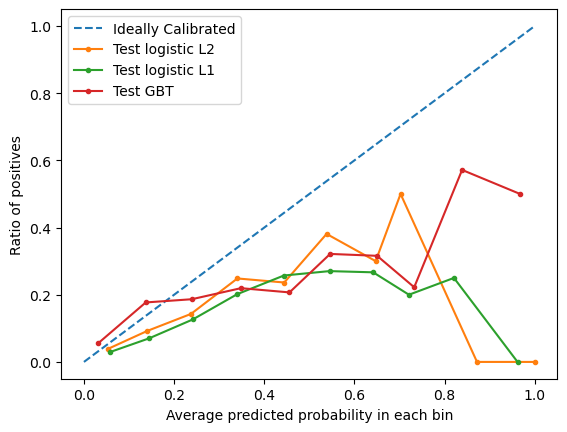

In [30]:
# plot calibration curves
from sklearn.calibration import calibration_curve

# Creating Calibration Curve
x1, y1 = calibration_curve(y_test, pred_test_gs, n_bins = 10, normalize = True)
x2, y2 = calibration_curve(y_test, pred_test_gs_l1, n_bins = 10, normalize = True)
x3, y3 = calibration_curve(y_test, pred_test_cal_gbt, n_bins = 10, normalize = True)

# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve
plt.plot(y1, x1, marker = '.', label = 'Test logistic L2')
plt.plot(y2, x2, marker = '.', label = 'Test logistic L1')
plt.plot(y3, x3, marker = '.', label = 'Test GBT')

leg = plt.legend(loc = 'upper left')
plt.xlabel('Average predicted probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()